# Carga de datos

In [19]:
from google.colab import files

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!pip install -q "kagglehub[pandas-datasets]"

import kagglehub
from kagglehub import KaggleDatasetAdapter


user_data = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "computingvictor/transactions-fraud-datasets",
  "users_data.csv"
)
cards_data = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "computingvictor/transactions-fraud-datasets",
  "cards_data.csv"
)
transactions_data = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "computingvictor/transactions-fraud-datasets",
  "transactions_data.csv"
)


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


<ipython-input-19-1602aeb8c008>:13: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  user_data = kagglehub.load_dataset(
<ipython-input-19-1602aeb8c008>:18: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  cards_data = kagglehub.load_dataset(
<ipython-input-19-1602aeb8c008>:23: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  transactions_data = kagglehub.load_dataset(


In [20]:
print(user_data.info())
print(cards_data.info())
print(transactions_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2000 non-null   int64  
 1   current_age        2000 non-null   int64  
 2   retirement_age     2000 non-null   int64  
 3   birth_year         2000 non-null   int64  
 4   birth_month        2000 non-null   int64  
 5   gender             2000 non-null   object 
 6   address            2000 non-null   object 
 7   latitude           2000 non-null   float64
 8   longitude          2000 non-null   float64
 9   per_capita_income  2000 non-null   object 
 10  yearly_income      2000 non-null   object 
 11  total_debt         2000 non-null   object 
 12  credit_score       2000 non-null   int64  
 13  num_credit_cards   2000 non-null   int64  
dtypes: float64(2), int64(7), object(5)
memory usage: 218.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6146 e

In [21]:
user_data.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,$37891,$77254,$191349,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,$22681,$33483,$196,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,$163145,$249925,$202328,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,$53797,$109687,$183855,675,1


In [22]:
cards_data.head()

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,2731,825,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,3701,825,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,42,825,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,4659,825,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No


# Transformación

In [23]:
transactions_data['amount'] = transactions_data['amount'].str.replace('$','').astype(float).copy()

In [24]:
import duckdb

data_joined = duckdb.query('''
SELECT user_data.id as user_id, transactions_data.mcc, SUM(amount) AS gasto
FROM transactions_data
INNER JOIN cards_data ON transactions_data.client_id = cards_data.client_id
INNER JOIN user_data ON cards_data.client_id = user_data.id
GROUP BY user_data.id, mcc''').df()

data_joined.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,user_id,mcc,gasto
0,876,5541,31812.68
1,734,5942,975.60
2,1525,5499,18175.20
3,940,5499,67000.20
4,1581,5411,211372.75


In [25]:
print(data_joined.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94163 entries, 0 to 94162
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  94163 non-null  int64  
 1   mcc      94163 non-null  int64  
 2   gasto    94163 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.2 MB
None


In [26]:
data = duckdb.query('''
SELECT data_joined.*,user_data.*
FROM data_joined
LEFT JOIN user_data ON data_joined.user_id = user_data.id

''').df()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94163 entries, 0 to 94162
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            94163 non-null  int64  
 1   mcc                94163 non-null  int64  
 2   gasto              94163 non-null  float64
 3   id                 94163 non-null  int64  
 4   current_age        94163 non-null  int64  
 5   retirement_age     94163 non-null  int64  
 6   birth_year         94163 non-null  int64  
 7   birth_month        94163 non-null  int64  
 8   gender             94163 non-null  object 
 9   address            94163 non-null  object 
 10  latitude           94163 non-null  float64
 11  longitude          94163 non-null  float64
 12  per_capita_income  94163 non-null  object 
 13  yearly_income      94163 non-null  object 
 14  total_debt         94163 non-null  object 
 15  credit_score       94163 non-null  int64  
 16  num_credit_cards   941

In [27]:
data['yearly_income'] = data['yearly_income'].str.replace('$','').astype(float).copy()
data['per_capita_income'] = data['per_capita_income'].str.replace('$','').astype(float).copy()
data['total_debt'] = data['total_debt'].str.replace('$','').astype(float).copy()
data['mcc'] = data['mcc'].astype(str).copy()

data.drop(['latitude','longitude','address','id'], axis=1, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94163 entries, 0 to 94162
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            94163 non-null  int64  
 1   mcc                94163 non-null  object 
 2   gasto              94163 non-null  float64
 3   current_age        94163 non-null  int64  
 4   retirement_age     94163 non-null  int64  
 5   birth_year         94163 non-null  int64  
 6   birth_month        94163 non-null  int64  
 7   gender             94163 non-null  object 
 8   per_capita_income  94163 non-null  float64
 9   yearly_income      94163 non-null  float64
 10  total_debt         94163 non-null  float64
 11  credit_score       94163 non-null  int64  
 12  num_credit_cards   94163 non-null  int64  
dtypes: float64(4), int64(7), object(2)
memory usage: 9.3+ MB


count    9.413700e+04
mean     2.321173e+04
std      8.900789e+04
min      3.000000e-02
25%      1.248200e+03
50%      3.844800e+03
75%      1.362060e+04
max      5.218320e+06
Name: gasto, dtype: float64


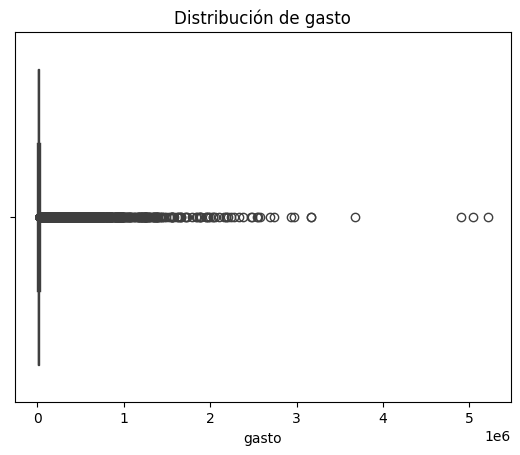

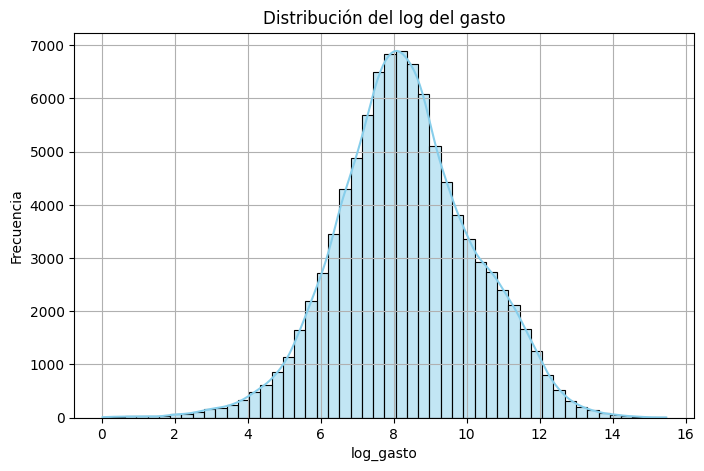

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
data = data[data['gasto']>0]
print(data['gasto'].describe())


sns.boxplot(x=data['gasto'])
plt.title("Distribución de gasto")
plt.show()

data["log_gasto"] = np.log1p(data["gasto"])

plt.figure(figsize=(8, 5))
sns.histplot(data["log_gasto"], bins=50, kde=True, color="skyblue")
plt.title("Distribución del log del gasto")
plt.xlabel("log_gasto")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

# Modelo Predictivo

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb



# Codificar variables categóricas
le_mcc = LabelEncoder()
le_gender = LabelEncoder()

data['mcc_enc'] = le_mcc.fit_transform(data['mcc'])
data['gender_enc'] = le_gender.fit_transform(data['gender'])

features = ['mcc_enc', 'current_age', 'retirement_age', 'birth_year', 'birth_month',
            'gender_enc', 'per_capita_income', 'yearly_income', 'total_debt',
            'credit_score', 'num_credit_cards']

X = data[features]
y = data['gasto']

train_users, test_users = train_test_split(data['user_id'].unique(), test_size=0.2, random_state=42)

train_idx = data['user_id'].isin(train_users)
test_idx = data['user_id'].isin(test_users)

X_train, y_train = X.loc[train_idx], y.loc[train_idx]
X_test, y_test = X.loc[test_idx], y.loc[test_idx]

# Entrenar XGBoost
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=1,
    n_jobs=-1
)

model.fit(X_train, y_train)

# Evaluar
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R2 score: {r2:.4f}")

RMSE: 77782.7705
R2 score: 0.2246


El modelo se puede mejorar haciendo un procesamiento de los datos antes de ingresarlo al modelo, se pueden sacar variables calculadas, verificar outliners y/o normalizar variables de entrada tanto como la variable de salida